### Avaliação de jogos de Xadrez (Depht=8)

Neste trabalho utilizaremos um dataset de jogos de xadrez feitos em determinado período no lichess.com. O dataset será tratado e serão extraidas apenas as colunas que serão uteis para esse trabalho. Depois de tratado, iremos avaliar cada movimento de cada um dos jogos por meio de uma engine de xadrez, curiosamente é a mesma usada no chess.com. Essa engine irá atribuir um valor numérico para cada movimento, indicando quem tem a maior vantagem e qual essa vantagem. Por fim, baseado nessa avaliação, separaremos os jogos em que houveram grandes desbalanceamentos e tentaremos estimar em qual movimento isso ocorre e qual a relação disso com o rating médio do jogo avaliado.

##### Requisitos:

- Pandas;

- Python Chess;

- Engine de xadrez Stockfish 15 (https://stockfishchess.org/files/stockfish_15_win_x64_avx2.zip) e deve estar dentro da pasta do projeto;

- MatPlotLib;

- NumPy.

Para instalar todos os requisitos (exceto o StockFish) basta executar o comando:

    pip install -r requirement.txt

#### Imports

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
import chess
import chess.pgn
import chess.engine

### Filtro para remover jogos não ranqueados

Para essa análise, as colunas uteis serão apenas as seguintes:

* Id;

* Quantidade de movimentos;

* O tipo de vitória;

* O vencedor;

* O rating dos jogadores;

* Os movimentos;

* O tipo de abertura;

* E quantos movimentos de livro foram feitos.

Portanto eliminaremos o resto das colunas. Além de, baseado na finalização de jogo mais rápida, remover os jogos com poucos movimentos e os jogos com mais do que 100 movimentos, pois são jogos que não acrescentarão em nada na análise, além de dificultar a avaliação pela engine.

In [2]:
if os.path.isfile("jogos.csv"):
    os.remove("jogos.csv")

columns = ["id", "rated", "created_at", "last_move_at", "turns", "victory_status", "winner", "increment_code", "white_id", "white_rating", "black_id", "black_rating", "moves", "opening_eco", "opening_name", "opening_ply"]

jogos = pd.read_csv("games.csv", usecols=columns)
jogos = jogos.drop(columns = ["created_at", "last_move_at", "increment_code", "white_id", "black_id", "opening_eco"])

jogos = jogos[jogos['rated'] == True]
jogos = jogos[jogos['turns'] >= 5]
jogos = jogos[jogos['turns'] <= 100]
jogos = jogos.drop(columns = ["rated"])
jogos = jogos.to_csv("jogos.csv")

#### Avaliação de cada movimento feito nas partidas

A análise será feita com um parâmetro reduzido para reduzir o tempo de execução (para a versão final, a profundidade da análise será feita em 15, para exemplo será usado 1)

O plano inicial seria rodar com a profundidade 20, porém seria em torno de 2 semanas processando os dados e assim, para reduzir o gasto energético, utilizaremos uma profundidade menor

In [3]:
engine = chess.engine.SimpleEngine.popen_uci(r"stockfish_15_win_x64_avx2/stockfish_15_x64_avx2.exe")
board = chess.Board()

if os.path.isfile("temporario.txt"):
    os.remove("temporario.txt")
if os.path.isfile("jogosAvaliados2.csv"):
    os.remove("jogosAvaliados2.csv")

columns = ["id", "turns", "victory_status", "winner", "white_rating", "black_rating", "moves", "opening_name", "opening_ply"]

jogos = pd.read_csv("jogos.csv", usecols=columns)

output = ""

jogos['moves_eval'] = ' '

i = 0

for index, row in jogos.iterrows():
    f = open("temporario.txt", "w")
    f.write("[White Rating: " + str(row["white_rating"]) + "] \n")
    f.write("[Black Rating: " + str(row["black_rating"]) + "] \n")
    f.write("[Winner: " + str(row["winner"]) + "] \n")
    f.write("\n")
    f.write(row["moves"])
    if (str(row["winner"]) == 'white'):
        f.write(" 1-0")
    elif (str(row["winner"]) == 'black'):
        f.write(" 0-1")
    else:
        f.write(" 1/2-1/2")
    f.write("\n")
    f.write("\n")

    f.close()
    f = open("temporario.txt", "r")

    gameMoves = chess.pgn.read_game(f)

    eval = ''

    for move in gameMoves.mainline_moves():
        board.push(move)
        info = engine.analyse(board, chess.engine.Limit(depth=8))
        eval += str(info["score"].white())
        eval += ' '

    row['moves_eval'] = eval
    jogos.iloc[index] = row

    board.reset()

    f.close()

    i = i + 1

engine.quit()

jogos.to_csv("jogosAvaliados2.csv")

#### Verificar em qual movimento há uma grande vantagem

O metodo de avaliação é feito em Centipawn, que é uma forma de estimar uma vantagem no jogo através de um valor atribuido às peças, como não temos como avaliar mais profundamente cada uma das situações possíveis em cada jogo, será apenas uma estimativa baseada no material disponivel e a mais simples. Os valores dependem da forma de avalição de cada autor/jogador. Usaremos os valores mais comuns:

* Peão (quem nomeia a escala): 100 pontos
* Cavalo: 300 pontos
* Bispo: 300 pontos
* Torre: 500 pontos
* Rainha: 900 pontos

Porém avaliar apenas se houve uma grande discrepancia de material em algum momento não é uma avaliação boa, porque durante um jogo existem situações em que é necessário "trocar peças", na qual você sacrifica uma peça para conseguir material do adversário ou reduzir as possibilidades de jogadas. Portanto não podemos apenas considerar apenas um movimento e sim um conjunto, assim então verificaremos se houve então uma vantagem maior do que 1000 pontos e se essa vantagem se manteve nos 3 seguintes movimentos, caso sim, não consideraremos uma troca de material. O valor 1000 é arbitário, bem como 3 para a quantidade de movimentos seguintes.

In [14]:
columnsEval = ["id", "turns", "victory_status", "winner", "white_rating", "black_rating", "moves", "opening_name", "opening_ply", "moves_eval"]

invalidMoves = ['', ' ', '#+0', '#+1', '#+2', '#+3', '#+4', '#+5', '#-0', '#-1', '#-2', '#-3', '#-4', '#-5', '#+6', '#-6', '#+8', '#+7', '#-7', '#-8', '#+9', '#+10', '#+11', '#+12', '#+13', '#+14', '#+15', '#-9', '#-10', '#-11', '#-12', '#-13', '#-14', '#-15']

jogosEval = pd.read_csv("jogosAvaliados2.csv", usecols=columnsEval)

if os.path.isfile("jogosAvaliadosEVerificados.csv"):
    os.remove("jogosAvaliadosEVerificados.csv")

flag = 0

jogosEval['valid'] = ' '

jogosEval['move_number'] = 0

movimento = 0

for index2, row2 in jogosEval.iterrows():
    movimentos = str(row2['moves_eval'])

    separados = movimentos.split(" ")

    flag = 0
    for mvn, mv in enumerate(separados):
        if mv not in invalidMoves:
            if (abs( int(mv) ) >= 1000):
                flag = flag + 1
            else:
                flag = 0

            if (flag == 1):
                movimento = mvn
            
            if (flag >= 3):
                row2['valid'] = 'True'
                break
    if (flag != 0):
        row2['move_number'] = movimento
    flag = 0
    movimento = 0
    
    jogosEval.iloc[index2] = row2

jogosEval = jogosEval[jogosEval['valid'] == 'True']
jogosEval.to_csv("jogosAvaliadosEVerificados.csv")

#### Separação por grupo de Rating

Para checar em quais em quais ratings mais ocorrem os desbalanceamentos ou mudanças abruptas, para isso separaremos os jogos em 4 grupos de acordo com o rating medio de cada partida:

* Beginner (0 - 999);

* Intermediate (1000 - 1499);

* Advanced (1500 - 2199);

* Master ( > 2200 )


In [15]:
columnsGroups = ["id", "turns", "victory_status", "winner", "white_rating", "black_rating", "moves", "opening_name", "opening_ply", "moves_eval", "valid", "move_number"]

jogosGroups = pd.read_csv("jogosAvaliadosEVerificados.csv", usecols=columnsGroups)

if os.path.isfile("grupos.csv"):
    os.remove("grupos.csv")

jogosGroups['group'] = ' '

for index3, row3 in jogosGroups.iterrows():
    
    rating = ( row3['white_rating'] + row3['black_rating'] ) / 2

    if (rating < 1000):
        row3['group'] = 'beginner'
    elif (rating < 1500):
        row3['group'] = 'intermediate'
    elif (rating < 2200):
        row3['group'] = 'advanced'
    else:
        row3['group'] = 'master'
    
    jogosGroups.iloc[index3] = row3


jogosGroups.to_csv("grupos.csv")


In [16]:
columnsGroups2 = ["white_rating", "black_rating"]

jogosGroups2 = pd.read_csv("jogos.csv", usecols=columnsGroups2)

if os.path.isfile("grupos2.csv"):
    os.remove("grupos2.csv")

jogosGroups2['group'] = ' '

for index4, row4 in jogosGroups2.iterrows():
    
    rating = ( row4['white_rating'] + row4['black_rating'] ) / 2

    if (rating < 1000):
        row4['group'] = 'beginner'
    elif (rating < 1500):
        row4['group'] = 'intermediate'
    elif (rating < 2200):
        row4['group'] = 'advanced'
    else:
        row4['group'] = 'master'
    
    jogosGroups2.iloc[index4] = row4


jogosGroups2.to_csv("grupos2.csv")

#### Quais as chances de acontecer um desbalanceamento em cada rating?

Após classificar em grupos, checaremos se é possível que o rating influencie na proporção de ocorrências. Assim separaremos quantas vezes ocorreu em cada grupo e a quantidade total de jogos avaliados de cada grupo e veremos quantos porcento dos jogos isso ocorreu por grupo.

In [17]:
columnsGraph = ["group"]

jogosGraph = pd.read_csv("grupos.csv", usecols=columnsGraph)
jogosGraph2 = pd.read_csv("grupos2.csv", usecols=columnsGraph)

grupos = ('beginner', 'intermediate', 'advanced', 'master')

c1 = 0
c2 = 0
c3 = 0
c4 = 0

d1 = 0
d2 = 0
d3 = 0
d4 = 0

for index5, row5 in jogosGraph.iterrows():
    if (row5['group'] == 'beginner'):
        c1 = c1 + 1
    elif (row5['group'] == 'intermediate'):
        c2 = c2 + 1
    elif (row5['group'] == 'advanced'):
        c3 = c3 + 1
    elif (row5['group'] == 'master'):
        c4 = c4 + 1

for index6, row6 in jogosGraph2.iterrows():
    if (row6['group'] == 'beginner'):
        d1 = d1 + 1
    elif (row6['group'] == 'intermediate'):
        d2 = d2 + 1
    elif (row6['group'] == 'advanced'):
        d3 = d3 + 1
    elif (row6['group'] == 'master'):
        d4 = d4 + 1

gruposNum = [c1, c2, c3, c4]
gruposNum2 = [d1, d2, d3, d4]

for x in range(len(gruposNum)):
    teste = gruposNum[x] / gruposNum2[x]
    print (grupos[x], teste)



beginner 0.5454545454545454
intermediate 0.46245797534553607
advanced 0.3249203626562117
master 0.18023255813953487


#### Conclusão

Com isso podemos ver que em valores relativos, o rating impacta diretamente na forma de jogo e em haver de fato um desbalanceamento, podendo ser visto que nos jogos de maior nivel como por exemplo os avançados possuem um menor desbalanceamento comparado aos jogos intermediarios. Por se tratar dos ratings mais comuns na base utilizada, será na qual a pesquisa estará mais direcionada, porém ainda serão mostradas os dados obtidos dos outros dois grupos. 

#### É possível estimar o movimento que ocorre?

Por fim, após comprovar que o rating interfere diretamente nessas grandes vantagens, verificaremos se é possível estimar em quais movimentos isso mais ocorre. Para isso, colocaremos em um gráfico e assim mesmo que não seja possível identificar qual o movimento exato, podemos estima pelo menos em qual techo do jogo isso ocorreu.

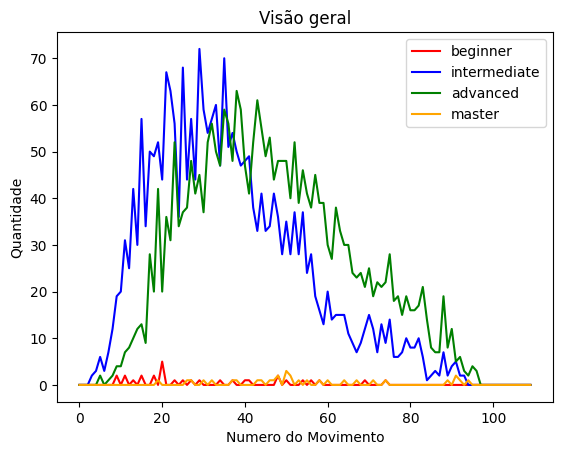

In [18]:
position = np.empty(110)
positionB = np.empty(110)
positionI = np.empty(110)
positionM = np.empty(110)
positionA = np.empty(110)
positionBR = np.empty(110)
positionIR = np.empty(110)
positionMR = np.empty(110)
positionAR = np.empty(110)
positionBM = np.empty(110)
positionIM = np.empty(110)
positionMM = np.empty(110)
positionAM = np.empty(110)

position.fill(int(0))
positionB.fill(int(0))
positionI.fill(int(0))
positionA.fill(int(0))
positionM.fill(int(0))
positionBR.fill(int(0))
positionIR.fill(int(0))
positionAR.fill(int(0))
positionMR.fill(int(0))
positionBM.fill(int(0))
positionIM.fill(int(0))
positionAM.fill(int(0))
positionMM.fill(int(0))

colunas = ["group", "move_number", "victory_status", "moves_eval", "winner"]

jogosGraph3 = pd.read_csv("grupos.csv", usecols=colunas)

for index7, row7 in jogosGraph3.iterrows():
    position[row7['move_number']] = position[row7['move_number']] + 1

    if (row7['group'] == 'beginner'):
        positionB[row7['move_number']] = positionB[row7['move_number']] + 1

        if(row7['victory_status'] == 'mate'):
            positionBM[row7['move_number']] = positionBM[row7['move_number']] + 1
        else: 
            positionBR[row7['move_number']] = positionBR[row7['move_number']] + 1

    elif (row7['group'] == 'intermediate'):
        positionI[row7['move_number']] = positionI[row7['move_number']] + 1

        if(row7['victory_status'] == 'mate'):
            positionIM[row7['move_number']] = positionIM[row7['move_number']] + 1
        else: 
            positionIR[row7['move_number']] = positionIR[row7['move_number']] + 1

    elif (row7['group'] == 'advanced'):
        positionA[row7['move_number']] = positionA[row7['move_number']] + 1

        if(row7['victory_status'] == 'mate'):
            positionAM[row7['move_number']] = positionAM[row7['move_number']] + 1
        else: 
            positionAR[row7['move_number']] = positionAR[row7['move_number']] + 1
        
    elif (row7['group'] == 'master'):
        positionM[row7['move_number']] = positionM[row7['move_number']] + 1

        if(row7['victory_status'] == 'mate'):
            positionMM[row7['move_number']] = positionMM[row7['move_number']] + 1
        else: 
            positionMR[row7['move_number']] = positionMR[row7['move_number']] + 1

x = position

y = np.arange(110)

plt.title("Visão geral")
plt.plot(y, positionB, color = "r", label = "beginner")
plt.plot(y, positionI, color = "b", label = "intermediate")
plt.plot(y, positionA, color = "g", label = "advanced")
plt.plot(y, positionM, color = "orange", label = "master")

plt.xlabel("Numero do Movimento")
plt.ylabel("Quantidade")

plt.legend()

plt.show()

#rating, numero do movimento e finalização


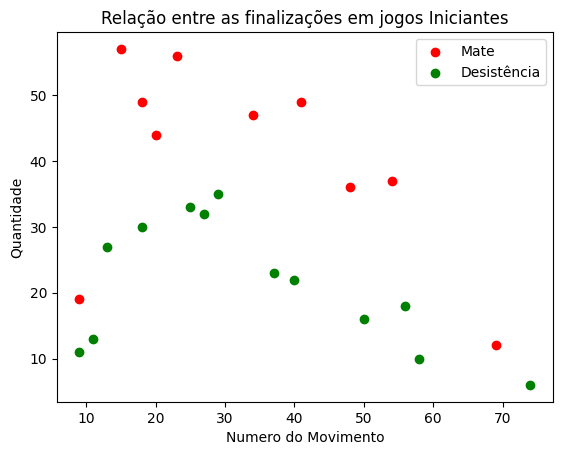

In [19]:
plt.scatter(y[positionBM > 0], positionI[positionBM > 0], c="r", label = "Mate")
plt.scatter(y[positionBR > 0], positionIR[positionBR > 0], c="g", label = "Desistência")

plt.title("Relação entre as finalizações em jogos Iniciantes")
plt.xlabel("Numero do Movimento")
plt.ylabel("Quantidade")

plt.legend()

plt.show()

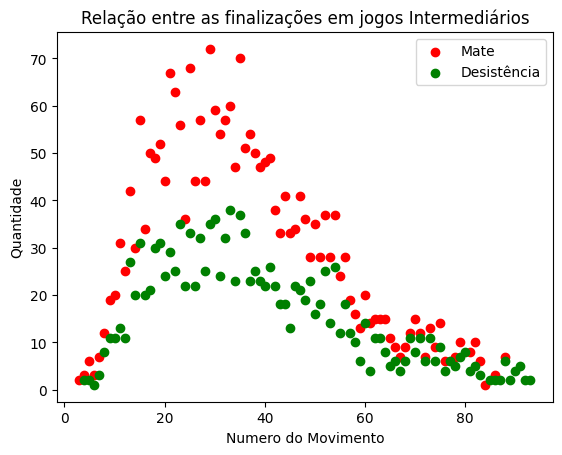

In [20]:

plt.scatter(y[positionIM > 0], positionI[positionIM > 0], c="r", label = "Mate")
plt.scatter(y[positionIR > 0], positionIR[positionIR > 0], c="g", label = "Desistência")

plt.title("Relação entre as finalizações em jogos Intermediários")
plt.xlabel("Numero do Movimento")
plt.ylabel("Quantidade")

plt.legend()

plt.show()


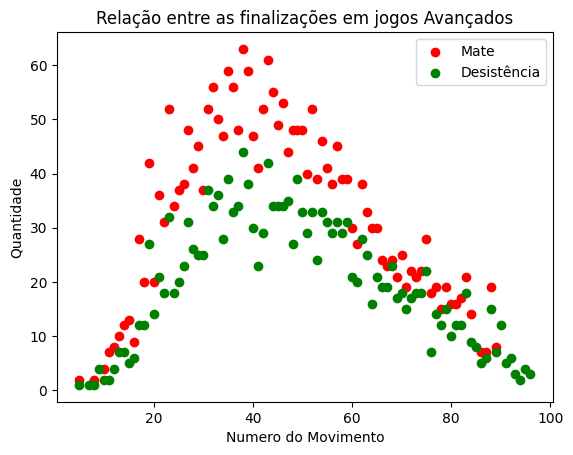

In [21]:
plt.scatter(y[positionAM > 0], positionA[positionAM > 0], c="r", label = "Mate")
plt.scatter(y[positionAR > 0], positionAR[positionAR > 0], c="g", label = "Desistência")

plt.title("Relação entre as finalizações em jogos Avançados")
plt.xlabel("Numero do Movimento")
plt.ylabel("Quantidade")

plt.legend()

plt.show()

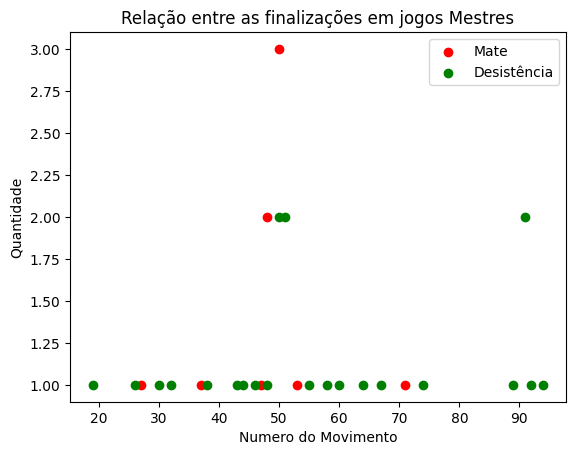

In [22]:
plt.scatter(y[positionMM > 0], positionM[positionMM > 0], c="r", label = "Mate")
plt.scatter(y[positionMR > 0], positionMR[positionMR > 0], c="g", label = "Desistência")

plt.title("Relação entre as finalizações em jogos Mestres")
plt.xlabel("Numero do Movimento")
plt.ylabel("Quantidade")

plt.legend()

plt.show()

#### Quanto disso realmente se tornou uma vitória?

Abaixo vamos analisar a quantidade de vitórias obtidas pelo lado que esteve em vantagem primeiro. Para isso plotaremos um gráfico com o número total de jogos de cada grupo e quantos deles foram vitórias para o lado com vantagem. Assim podendo estimar se essa vantagem foi realmente aproveitada ou se foi desperdiçada.

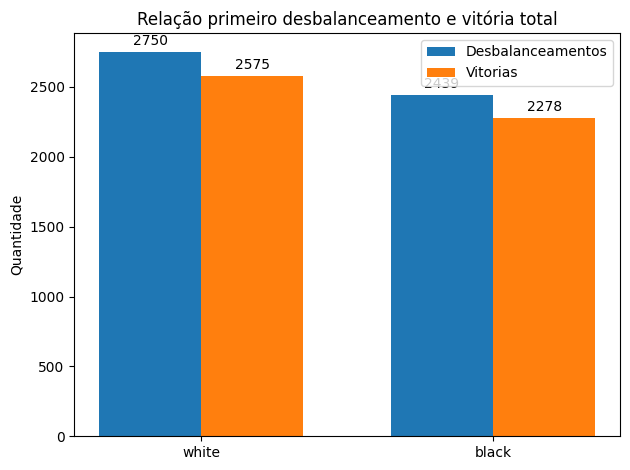

In [23]:
desb = np.empty(2)
win = np.empty(2)

desb.fill(int(0))
win.fill(int(0))

fig, ax = plt.subplots()

for index8, row8 in jogosGraph3.iterrows():
    separados2 = row8['moves_eval'].split(" ")

    if ( int(separados2[ int(row8['move_number']) ]) > 0 ):
        desb[0] = desb[0] + 1

        if (row8['winner'] == 'white'):
            win[0] = win[0] + 1
    else:
        desb[1] = desb[1] + 1

        if (row8['winner'] == 'black'):
            win[1] = win[1] + 1

y2 = np.arange(len(desb))
labels = ['white', 'black']
grup2 = np.arange(len(labels))

width = 0.35

rects1 = ax.bar(grup2 - width/2, desb, width, label='Desbalanceamentos')
rects2 = ax.bar(grup2 + width/2, win, width, label='Vitorias')
ax.set_xticks(grup2, labels)
ax.legend()

ax.set_ylabel('Quantidade')
ax.set_title('Relação primeiro desbalanceamento e vitória total')
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()



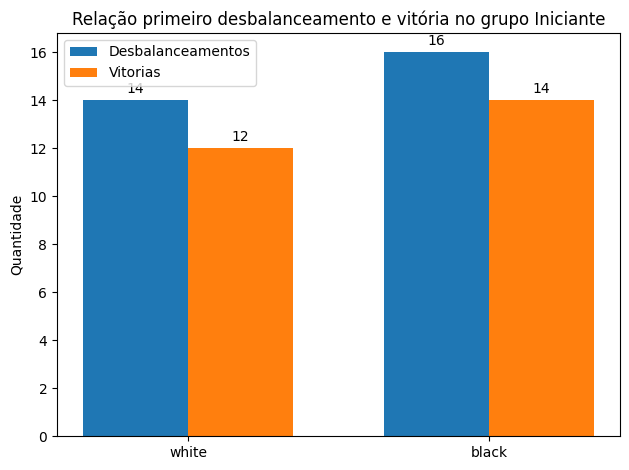

In [24]:
desb = np.empty(2)
win = np.empty(2)

desb.fill(int(0))
win.fill(int(0))

fig, ax = plt.subplots()

for index8, row8 in jogosGraph3.iterrows():
    
    if (row8['group'] == 'beginner'):
        separados2 = row8['moves_eval'].split(" ")

        if ( int(separados2[ int(row8['move_number']) ]) > 0 ):
            desb[0] = desb[0] + 1

            if (row8['winner'] == 'white'):
                win[0] = win[0] + 1
        else:
            desb[1] = desb[1] + 1

            if (row8['winner'] == 'black'):
                win[1] = win[1] + 1

y2 = np.arange(len(desb))
labels = ['white', 'black']
grup2 = np.arange(len(labels))

width = 0.35

rects1 = ax.bar(grup2 - width/2, desb, width, label='Desbalanceamentos')
rects2 = ax.bar(grup2 + width/2, win, width, label='Vitorias')
ax.set_xticks(grup2, labels)
ax.legend()

ax.set_ylabel('Quantidade')
ax.set_title('Relação primeiro desbalanceamento e vitória no grupo Iniciante')
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

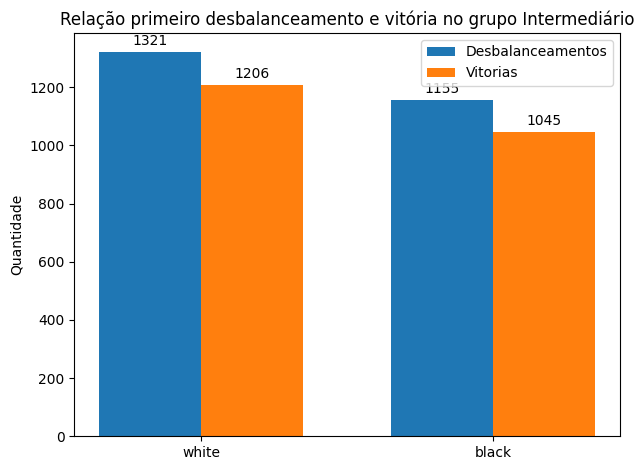

In [25]:
desb = np.empty(2)
win = np.empty(2)

desb.fill(int(0))
win.fill(int(0))

fig, ax = plt.subplots()

for index8, row8 in jogosGraph3.iterrows():
    
    if (row8['group'] == 'intermediate'):
        separados2 = row8['moves_eval'].split(" ")

        if ( int(separados2[ int(row8['move_number']) ]) > 0 ):
            desb[0] = desb[0] + 1

            if (row8['winner'] == 'white'):
                win[0] = win[0] + 1
        else:
            desb[1] = desb[1] + 1

            if (row8['winner'] == 'black'):
                win[1] = win[1] + 1

y2 = np.arange(len(desb))
labels = ['white', 'black']
grup2 = np.arange(len(labels))

width = 0.35

rects1 = ax.bar(grup2 - width/2, desb, width, label='Desbalanceamentos')
rects2 = ax.bar(grup2 + width/2, win, width, label='Vitorias')
ax.set_xticks(grup2, labels)
ax.legend()

ax.set_ylabel('Quantidade')
ax.set_title('Relação primeiro desbalanceamento e vitória no grupo Intermediário')
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

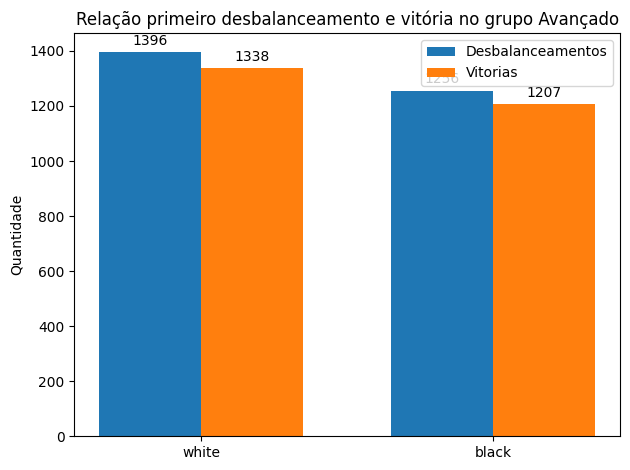

In [26]:
desb = np.empty(2)
win = np.empty(2)

desb.fill(int(0))
win.fill(int(0))

fig, ax = plt.subplots()

for index8, row8 in jogosGraph3.iterrows():
    
    if (row8['group'] == 'advanced'):
        separados2 = row8['moves_eval'].split(" ")

        if ( int(separados2[ int(row8['move_number']) ]) > 0 ):
            desb[0] = desb[0] + 1

            if (row8['winner'] == 'white'):
                win[0] = win[0] + 1
        else:
            desb[1] = desb[1] + 1

            if (row8['winner'] == 'black'):
                win[1] = win[1] + 1

y2 = np.arange(len(desb))
labels = ['white', 'black']
grup2 = np.arange(len(labels))

width = 0.35

rects1 = ax.bar(grup2 - width/2, desb, width, label='Desbalanceamentos')
rects2 = ax.bar(grup2 + width/2, win, width, label='Vitorias')
ax.set_xticks(grup2, labels)
ax.legend()

ax.set_ylabel('Quantidade')
ax.set_title('Relação primeiro desbalanceamento e vitória no grupo Avançado')
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

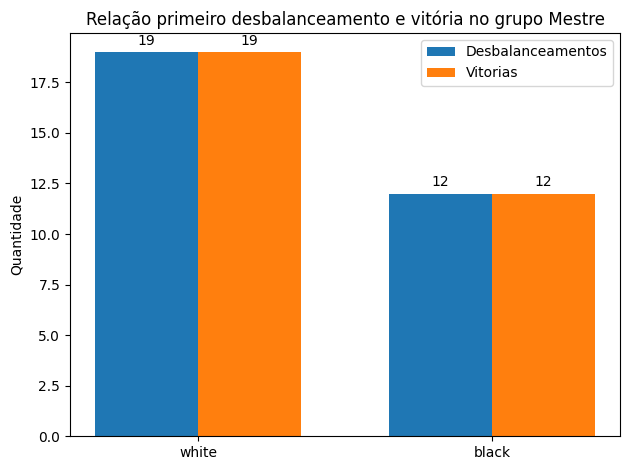

In [27]:
desb = np.empty(2)
win = np.empty(2)

desb.fill(int(0))
win.fill(int(0))

fig, ax = plt.subplots()

for index8, row8 in jogosGraph3.iterrows():
    
    if (row8['group'] == 'master'):
        separados2 = row8['moves_eval'].split(" ")

        if ( int(separados2[ int(row8['move_number']) ]) > 0 ):
            desb[0] = desb[0] + 1

            if (row8['winner'] == 'white'):
                win[0] = win[0] + 1
        else:
            desb[1] = desb[1] + 1

            if (row8['winner'] == 'black'):
                win[1] = win[1] + 1

y2 = np.arange(len(desb))
labels = ['white', 'black']
grup2 = np.arange(len(labels))

width = 0.35

rects1 = ax.bar(grup2 - width/2, desb, width, label='Desbalanceamentos')
rects2 = ax.bar(grup2 + width/2, win, width, label='Vitorias')
ax.set_xticks(grup2, labels)
ax.legend()

ax.set_ylabel('Quantidade')
ax.set_title('Relação primeiro desbalanceamento e vitória no grupo Mestre')
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

#### Resultados

Para concluir, além de ser mais fácil de visualizar o maior número de desbalanceios nos ratings inferiores, o mais próximo de uma estimativa de qual movimento esse desbalanceio acontece, é citar que o começo entre os movimentos 20 e 50 são onde ocorrem a maior parte deles. Ou seja, do meio para o final do jogo. Além disso, foi possível concluir que o primeiro desbalanceamento ocorrido na partida, na maior parte das vezes, se tornou uma vitória para o lado que estava em vantagem.